# Code to find the resolution of the model
We want to find the resolution between the predicted and true vertex

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import uproot
from typing import List
import os

import torch
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import ResGatedGraphConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.nn.norm import BatchNorm
from torch.nn import Dropout, Linear, Sigmoid, LogSoftmax, ReLU, LeakyReLU, SiLU

sys.path.append('/sps/t2k/cehrhardt/Caverns/WatChMaL/watchmal/model/grant_gnn.py')
sys.path.append('/sps/t2k/cehrhardt/analysis_tools/tools')

from test_GCN.utils import train, Normalize
from Caverns.WatChMaL.watchmal.model.grant_gnn import ResGateConv_v2, ResGateConv_v3
from tools.dataset_from_processed import DatasetFromProcessed
from analysis_tools.tools.old import decompose_vector, cartesian_to_cylindrical, cartesian_to_cylindrical_batch, vector_projection, project_to_new_basis, project_to_new_basis_batch


### Load data

In [15]:
feat_max = [3250, 3250, 3300, 500, 420]
feat_min = [-3250, -3250, -3300, -600, 0]

label_max = [3250, 3250, 3300, 250]
label_min = [-3250, -3250, -3300, -1200]

transform = torch_geometric.transforms.Compose([Normalize(feat_norm=[feat_max,feat_min], label_norm=[label_max, label_min])])

In [28]:
dataset = DatasetFromProcessed(graph_folder_path = '/sps/t2k/cehrhardt/dataset/graph_1.5M_hitxyztc_t_xyzt_r12', graph_file_names = ['data.pt'],  verbose = 1, transform=transform)

#### to check

In [4]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[2]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: DatasetFromProcessed(20):
Number of graphs: 20
Number of features: 5
Number of classes: 80

Data(x=[131, 5], y=[4], pos=[131, 1], edge_index=[2, 1542], idx=2)
Number of nodes: 131
Number of edges: 1542
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/sps/t2k/cehrhardt/miniconda3/envs/klaimbaywatch/lib/python3.10/site-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


### Index split of the dataset of graph

In [29]:
index_list = np.load('/sps/t2k/cehrhardt/Caverns/index_lists/UnifVtx_electron_HK_10MeV_train_val_test_1.5M.npz')

print("Arrays in the .npz file:", index_list.files)

for array_name in index_list.files:
    print(f"Array '{array_name}':")
    print(index_list[array_name])

# sample_size = 10000  # Define the sample size
# sampled_train_idx = np.random.choice(index_list['test_idxs'], size=sample_size, replace=False)

sampled_train_data = dataset[index_list['test_idxs']]

# predict_loader = DataLoader(sampled_train_data, batch_size=1, shuffle=True)

# sampled = dataset[index_list['test_idxs']]

loader = DataLoader(sampled_train_data, batch_size=10000, shuffle=True)

Arrays in the .npz file: ['train_idxs', 'val_idxs', 'test_idxs']
Array 'train_idxs':
[ 773272  466583  219689 ... 1229588  666340   81152]
Array 'val_idxs':
[1355944  299735  490692 ...  995797  549654  262916]
Array 'test_idxs':
[ 160765  309319 1262084 ... 1070315 1378193  776756]


## Load model

Defining the best modele by loading our class model and updating its parameters from the best parameter dictionnary of the training

In [30]:
class ResGateConv_activation(torch.nn.Module):
    r""""
    Args :
        in_channels : Number of features per node in the graph
        conv_kernels : The number of filters for each layer starting from the 2nd. The len defines 
            the number of layers.
        linear_out_features : The number of neurones at the end of each Linear layer. 
            The len defines the number of layers. 
            The last element of the list gives the number of classes the model will predict
    """
    def __init__(
        self,
        in_channels: int,
        conv_activation,
        linear_activation,
        conv_in_channels: List[int],
        linear_out_features: List[int],
        dropout: float = 0.2,
    ) -> None:

        super().__init__() # If more heritage than torch.nn.Module is added, modify this according to the changes


        self.conv_layers = torch.nn.ModuleList()
        self.cl_norms = torch.nn.ModuleList()

        # Define the convolutional and normalization layers
        for i in range(len(conv_in_channels)):
            in_channels = in_channels if i == 0 else conv_in_channels[i - 1] # Erwan : Sure to be a good idea ? Maybe enforce some check from the user (just use in_conv_feat)
            out_channels = conv_in_channels[i]
            self.conv_layers.append(ResGatedGraphConv(in_channels, out_channels))
            self.cl_norms.append(BatchNorm(out_channels))

        self.gap_norm = BatchNorm(conv_in_channels[-1])
        self.gsp_norm = BatchNorm(conv_in_channels[-1])

        self.hidden_layers = torch.nn.ModuleList()
        self.hl_norms = torch.nn.ModuleList()

        # Define the hidden and normalization layers
        first_linear_in_features = 2 * conv_in_channels[-1] # Times 2 because of the torch.cat on gap and gsp

        for j in range(len(linear_out_features) - 1):
            in_features  = first_linear_in_features if j == 0 else linear_out_features[j - 1]
            out_features = linear_out_features[j]
            self.hidden_layers.append(Linear(in_features, out_features))
            self.hl_norms.append(BatchNorm(out_features))

        # Last layer doesn't have batch_norm
        self.last_layer = Linear(linear_out_features[-2], linear_out_features[-1])

        self.drop = Dropout(p=dropout)

        self.activation_cl = conv_activation
        self.activation_hl = linear_activation

        
        # DO NOT add a sigmoid layer for the output (it is handled by the loss)
        # if it's not a sigmoid then define the output activation here
        # And then use BCELoss as a loss function (and not BCEwithlogitsloss)
        self.output_activation = None # ReLU()..


    def forward(self, data: torch_geometric.data.Data) -> torch.Tensor:
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Apply convolutional layers
        for conv_layer, norm_layer in zip(self.conv_layers, self.cl_norms):
            x = conv_layer(x, edge_index)
            x = self.activation_cl(x)
            x = norm_layer(x)
            x = self.drop(x)

        # Global pooling 
        # Terminologie : gap, très moyen vu que global_add_pool existe aussi..
        xs_gap = global_mean_pool(x, batch)
        xs_gsp = global_max_pool(x, batch)

        xs_gap = self.gap_norm(xs_gap)       
        xs_gsp = self.gsp_norm(xs_gsp)

        out = torch.cat((xs_gap, xs_gsp), dim=1) # out.shape = (batch_size, 2 * conv_in_channels[-1])

        # Apply hidden layers
        for _, (hidden_layer, norm_layer) in enumerate(zip(self.hidden_layers, self.hl_norms)):
            out = hidden_layer(out)
            out = self.activation_hl(out)   # Best thing would probably to add the last layer apart in __init__
            out = norm_layer(out)
            
            # if i < len(self.hidden_layers) - 1: # The last block won't have an activation and a norm layer
            #     out = self.activation_hl(out)   # Best thing would probably to add the last layer apart in __init__
            #     out = norm_layer(out)

        out =  self.last_layer(out)
        if self.output_activation is not None:
            out = self.output_activation(out)

        return out

In [31]:
best = "/sps/t2k/cehrhardt/Caverns/WatChMaL/outputs/2024-06-26/07-57-24/RegressionEngine_ResGateConv_activation_BEST.pth"

# Load data from the .pth file
checkpoint = torch.load(best, map_location=torch.device('cpu'))

print(checkpoint.keys())

dict_keys(['global_step', 'optimizer', 'state_dict'])


In [32]:
nb_label=4
# untrained_model = ResGateConv_activation(5, [32, 64, 64], [128, 32, nb_label], 0)
best_model = ResGateConv_activation(5, LeakyReLU(0.1), SiLU(), [32, 64, 64], [128, 32, nb_label], 0)

best_model.load_state_dict(checkpoint['state_dict'])
best_model.eval()

ResGateConv_activation(
  (conv_layers): ModuleList(
    (0): ResGatedGraphConv(5, 32)
    (1): ResGatedGraphConv(32, 64)
    (2): ResGatedGraphConv(64, 64)
  )
  (cl_norms): ModuleList(
    (0): BatchNorm(32)
    (1-2): 2 x BatchNorm(64)
  )
  (gap_norm): BatchNorm(64)
  (gsp_norm): BatchNorm(64)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=32, bias=True)
  )
  (hl_norms): ModuleList(
    (0): BatchNorm(128)
    (1): BatchNorm(32)
  )
  (last_layer): Linear(in_features=32, out_features=4, bias=True)
  (drop): Dropout(p=0, inplace=False)
  (activation_cl): LeakyReLU(negative_slope=0.1)
  (activation_hl): SiLU()
)

## Output investigation

In [17]:
predictions_last = []
predictions_first = []
# targets = []
pooling = []


for data in loader:  
    out_last = best_model(data) 
    out_first = untrained_model(data)
    predictions_last.append(out_last.detach().cpu().numpy())
    predictions_first.append(out_first.detach().cpu().numpy())


predictions_last = np.array([np.concatenate(predictions_last, axis=0)])
predictions_last = predictions_last.reshape(300000,4)
predictions_last = predictions_last * (np.array(label_max) - np.array(label_min)) + np.array(label_min)

predictions_first = np.array([np.concatenate(predictions_first, axis=0)])
predictions_first = predictions_first.reshape(300000,4)
predictions_first = predictions_first * (np.array(label_max) - np.array(label_min)) + np.array(label_min)

In [35]:
np.savez('/sps/t2k/cehrhardt/analysis_tools/prediction.npz', trained = predictions_last , untrained = predictions_first)

In [2]:
predictions = np.load('/sps/t2k/cehrhardt/analysis_tools/prediction.npz')
predictions_first = predictions['untrained']
predictions_last = predictions['trained']

In [4]:
len(predictions_last)

300000

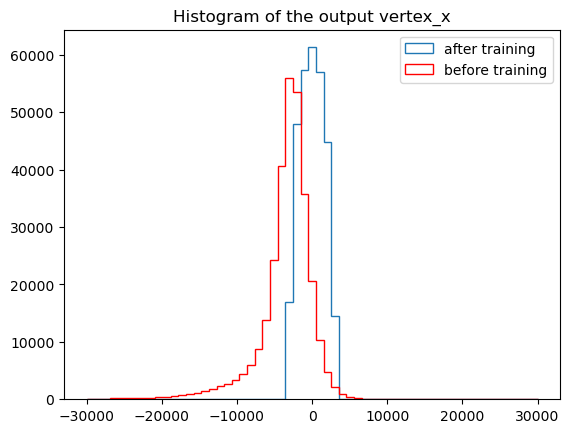

In [16]:
bin_edges = np.linspace(-30000, 30000, 60)
plt.hist(predictions_last[:,0], bins=bin_edges, histtype='step', label = 'after training')
plt.hist(predictions_first[:,0], bins=bin_edges, histtype='step', color='r', label = 'before training')
plt.title('Histogram of the output vertex_x')
# plt.yscale('log')
plt.legend()
plt.show()

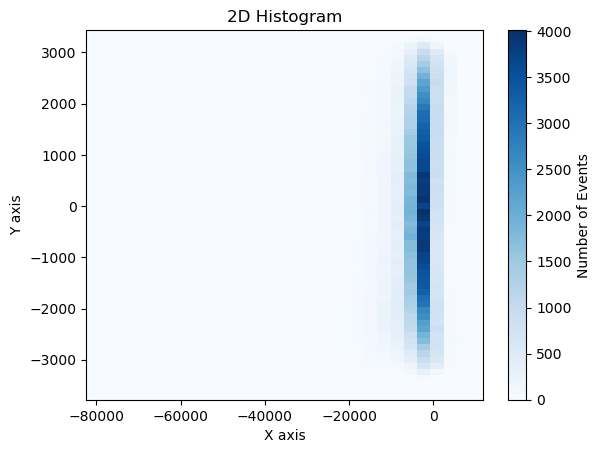

In [15]:
x_bins = 30
y_bins = 60

plt.hist2d(predictions_first[:,0], predictions_last[:,0], bins=[x_bins, y_bins], cmap='Blues')
plt.colorbar(label='Number of Events')
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('2D Histogram')
plt.show()


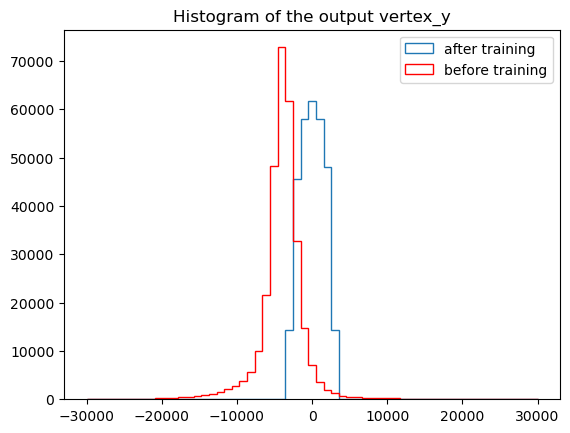

In [17]:
bin_edges = np.linspace(-30000, 30000, 60)
plt.hist(predictions_last[:,1], bins=bin_edges, histtype='step', label = 'after training')
plt.hist(predictions_first[:, 1], bins=bin_edges, histtype='step', color='r', label = 'before training')
plt.title('Histogram of the output vertex_y')
# plt.yscale('log')
plt.legend()
plt.show()

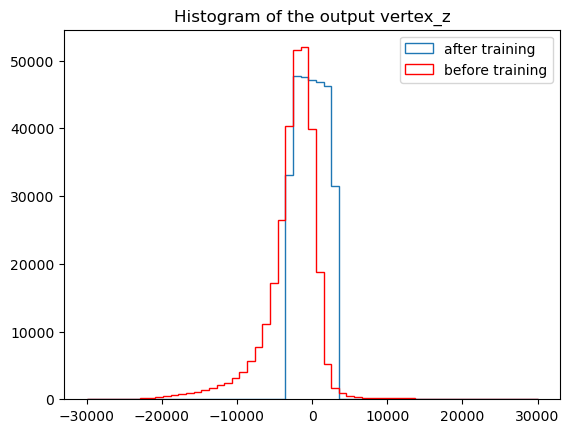

In [18]:
bin_edges = np.linspace(-30000, 30000, 60)
plt.hist(predictions_last[:,2], bins=bin_edges, histtype='step', label = 'after training')
plt.hist(predictions_first[:, 2], bins=bin_edges, histtype='step', color='r', label = 'before training')
plt.title('Histogram of the output vertex_z')
# plt.yscale('log')
plt.legend()
plt.show()

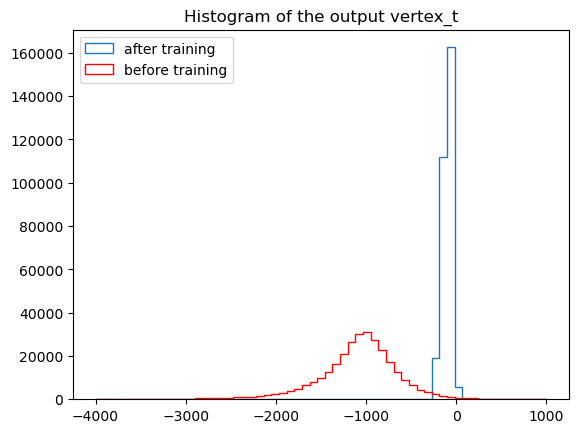

In [22]:
bin_edges = np.linspace(-4000, 1000, 60)
plt.hist(predictions_last[:,3], bins=bin_edges, histtype='step', label = 'after training')
plt.hist(predictions_first[:,3], bins=bin_edges, histtype='step', color='r', label = 'before training')
plt.title('Histogram of the output vertex_t')
# plt.yscale('log')
plt.legend()
plt.show()

## Predict

In [33]:
predictions = []
targets = []
pooling = []


for data in loader:  
    out = best_model(data) 
    
    predictions.append(out.detach().cpu().numpy())
    targets.append(data.y.detach().cpu().numpy())

# pooling = np.concatenate(pooling, axis=0)
# pooling = pooling.reshape(256 ,nb_label)

predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)
targets = targets.reshape(predictions.shape[0],nb_label)

### out histo

In [34]:
np.savez('/sps/t2k/cehrhardt/analysis_tools/out.npz', out = predictions, true = targets)

In [17]:
out = np.load('/sps/t2k/cehrhardt/analysis_tools/out.npz')
predict = out['out'] * (np.array(label_max) - np.array(label_min)) + np.array(label_min)
true = out['true']* (np.array(label_max) - np.array(label_min)) + np.array(label_min)

In [20]:
true

array([[ 1717.56055951,   495.77891827, -3072.22459763,  -112.00002134],
       [ 2305.90623617,  1905.01594543, -2404.27022874,  -118.00002456],
       [ -416.94307327, -2916.24291055,   301.34904385,   -36.37498617],
       ...,
       [-2039.11483288,  -994.50986087,  2427.43159533,  -100.40622056],
       [   36.60517931,  -413.35004568,  2301.88765526,  -140.40624201],
       [ 2311.6157949 ,   285.71581841,  -968.02661419,  -108.40622485]])

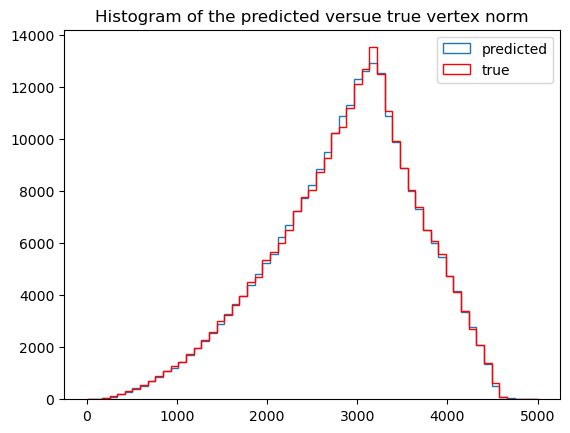

In [25]:
bin_edges = np.linspace(0, 5000, 60)
plt.hist(np.sqrt(predict[:,0]**2+predict[:,1]**2+predict[:,2]**2), bins=bin_edges, histtype='step', label = 'predicted')
plt.hist(np.sqrt(true[:,0]**2+true[:,1]**2+true[:,2]**2), bins=bin_edges, histtype='step', color='r', label = 'true')
plt.title('Histogram of the predicted versue true vertex norm')
# plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


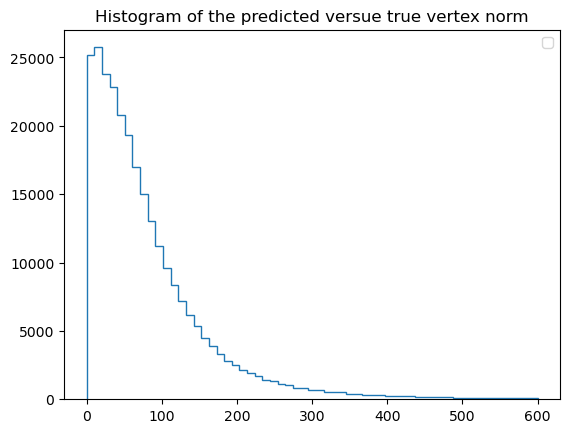

In [31]:
bin_edges = np.linspace(-0.1, 600, 60)
plt.hist(np.abs(np.sqrt(predict[:,0]**2+predict[:,1]**2+predict[:,2]**2)-np.sqrt(true[:,0]**2+true[:,1]**2+true[:,2]**2)), bins=bin_edges, histtype='step')
plt.title('Histogram of the predicted versue true vertex norm')
# plt.yscale('log')
# plt.legend()
plt.show()

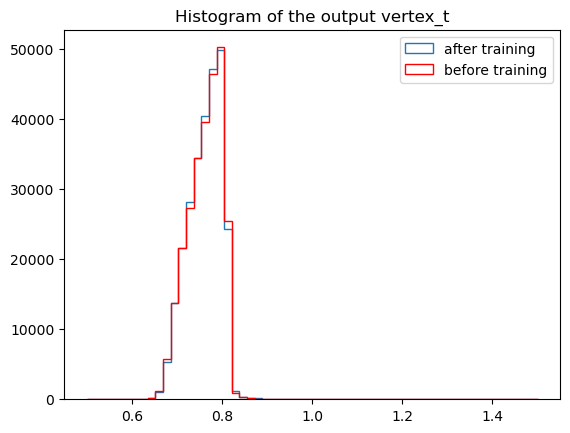

In [7]:
bin_edges = np.linspace(0.5, 1.5, 60)
plt.hist(predict[:,3], bins=bin_edges, histtype='step', label = 'after training')
plt.hist(true[:,3], bins=bin_edges, histtype='step', color='r', label = 'before training')
plt.title('Histogram of the output vertex_t')
# plt.yscale('log')
plt.legend()
plt.show()

### Compute resolution

In [24]:
norm_pos_all=np.array([])
norm_time_all=np.array([])
norm_time_abs_all=np.array([])

for true_data, predict_data in zip(targets, predictions):

    true=np.array([true_data]) * (np.array(label_max) - np.array(label_min)) + np.array(label_min)

    predict = np.array([predict_data]) * (np.array(label_max) - np.array(label_min)) + np.array(label_min) #eps=1e-12 neglected

    predict_vtx = predict[:,:3]
    true_vtx = true[:,:3]
    
    norm_pos = predict_vtx - true_vtx
    norm_pos = np.linalg.norm(norm_pos, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each event

    norm_time = predict[:,3] - true[:,3]
    norm_time_abs = np.abs(norm_time)  # Compute absolute value

    norm_pos_all=np.append(norm_pos_all, norm_pos)
    norm_time_all=np.append(norm_time_all, norm_time)
    norm_time_abs_all=np.append(norm_time_abs_all, norm_time_abs)

res_time = np.quantile(norm_time_abs_all, 0.68, axis=0)
cred_int = np.quantile(norm_time_all, 0.16, axis=0), np.quantile(norm_time_all, 0.84, axis=0)
res_pos = np.quantile(norm_pos_all, 0.68, axis=0)


print(f"Resolution at 68% for:\n- on the position norm: {res_pos:.2f} cm\n- on time: {res_time:.2f} ns\nCredible interval on time at 68%: {cred_int[0]:.2f} ns to {cred_int[1]:.2f} ns")

Resolution at 68% for:
- on the position norm: 979.65 cm
- on time: 76.38 ns
Credible interval on time at 68%: -86.56 ns to -43.33 ns


## Old

#### plots

In [ ]:
norm_pos_all=np.array([])
norm_time_all=np.array([])
norm_time_abs_all=np.array([])
norm_pos_p_all=np.array([])
norm_pos_o_all=np.array([])

for true_data, predict_data in zip(dataset, predictions):

    true=np.array([true_data.y])
    true = true.reshape(test_batch_size,4)

    predict = predict_data * (np.array(label_max) - np.array(label_min)) + np.array(label_min) #eps=1e-12 neglected
    
    predict_vtx = predict[:,:3]
    true_vtx = true[:,:3]
    
    norm_pos = predict_vtx - true_vtx
    norm_pos = np.linalg.norm(norm_pos, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each event

    norm_time = predict[:,3] - true[:,3]
    norm_time_abs = np.abs(norm_time)  # Compute absolute value

    norm_pos_all=np.append(norm_pos_all, norm_pos)
    norm_time_all=np.append(norm_time_all, norm_time)
    norm_time_abs_all=np.append(norm_time_abs_all, norm_time_abs)


    true_para, true_ortho = decompose_vector(true_vtx, dir)
    
    predict_para, predict_ortho = decompose_vector(predict_vtx, dir)
    
    norm_pos_p = predict_para - true_para
    norm_pos_p = np.linalg.norm(norm_pos_p, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each batch
    norm_pos_p_all=np.append(norm_pos_p_all, norm_pos_p)

    norm_pos_o = predict_ortho - true_ortho
    norm_pos_o = np.linalg.norm(norm_pos_o, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each batch
    norm_pos_o_all=np.append(norm_pos_o_all, norm_pos_o)
    break

res_time = np.quantile(norm_time_abs_all, 0.68, axis=0)
cred_int = np.quantile(norm_time_all, 0.16, axis=0), np.quantile(norm_time_all, 0.84, axis=0)
res_pos = np.quantile(norm_pos_all, 0.68, axis=0)
res_pos_para = np.quantile(norm_pos_p_all, 0.68, axis=0)
res_pos_ortho = np.quantile(norm_pos_o_all, 0.68, axis=0)
check = np.sqrt(res_pos_para**2 + res_pos_ortho**2)


print(f"Resolution at 68% for:\n- on the position norm: {res_pos:.2f} cm \n- on the direction projection: {res_pos_para:.2f} cm\n- orthogonal to the direction projection: {res_pos_ortho:.2f} cm\n- on time: {res_time:.2f} ns\nCredible interval on time at 68%: {cred_int[0]:.2f} ns to {cred_int[1]:.2f} ns")

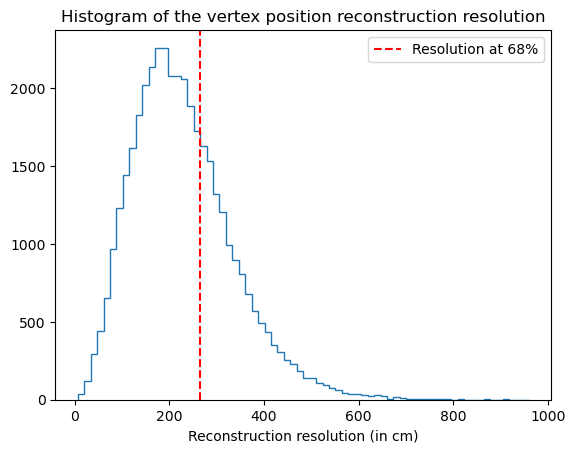

In [64]:
plt.hist(norm_pos[norm_pos<1000], bins=70, histtype='step')
# plt.hist(norm_pos, bins=62, histtype='step')


plt.axvline(x=res['position'], color='r', linestyle='--', linewidth=1.5, label='Resolution at 68%')


plt.legend()
plt.xlabel('Reconstruction resolution (in cm)')
plt.title('Histogram of the vertex position reconstruction resolution')

plt.show()

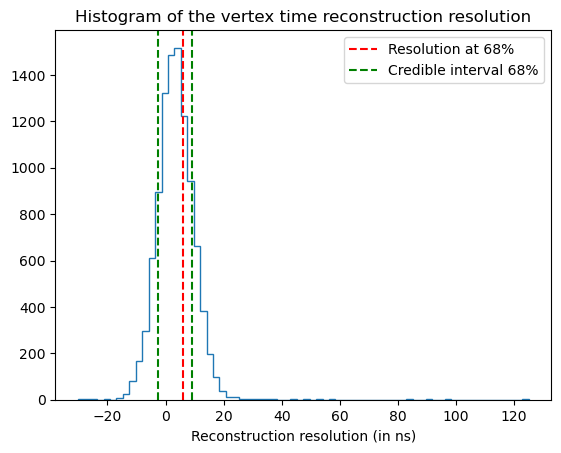

In [122]:
plt.hist(norm_time, bins=70, histtype='step')
# plt.hist(norm_time[(norm_time<1000) & (norm_time>-100)], bins=70, histtype='step')
# plt.yscale('log')

plt.axvline(x=res['time'], color='r', linestyle='--', linewidth=1.5, label='Resolution at 68%')


plt.axvline(x=res['cred_int'][0], color='g', linestyle='--', linewidth=1.5, label='Credible interval 68%')
plt.axvline(x=res['cred_int'][1], color='g', linestyle='--', linewidth=1.5)

plt.legend()

plt.xlabel('Reconstruction resolution (in ns)')
plt.title('Histogram of the vertex time reconstruction resolution')

plt.show()

#### comparison noise and no noise

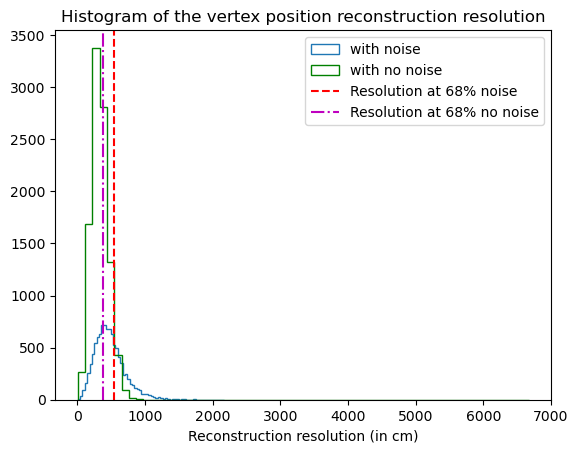

In [ ]:
# plt.hist(norm_pos[norm_pos<1000], bins=70, histtype='step')
plt.hist(norm_pos, bins=62, histtype='step', label='with noise') # refaire les bins avec bins edge et linspace 
plt.hist(norm_pos2, bins=62, histtype='step', label='with no noise', color='green')


plt.axvline(x=res['position'], color='r', linestyle='--', linewidth=1.5, label='Resolution at 68% noise')
plt.axvline(x=res2['position'], color='m', linestyle='dashdot', linewidth=1.5, label='Resolution at 68% no noise')


plt.legend()
plt.xlabel('Reconstruction resolution (in cm)')
plt.title('Histogram of the vertex position reconstruction resolution')

plt.show()

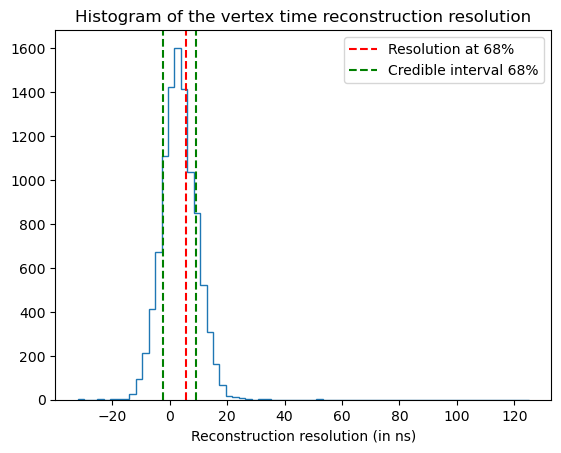

In [101]:
plt.hist(norm_time, bins=70, histtype='step')
# plt.hist(norm_time[(norm_time<1000) & (norm_time>-100)], bins=70, histtype='step')
# plt.yscale('log')

plt.axvline(x=res['time'], color='r', linestyle='--', linewidth=1.5, label='Resolution at 68%')


plt.axvline(x=res['cred_int'][0], color='g', linestyle='--', linewidth=1.5, label='Credible interval 68%')
plt.axvline(x=res['cred_int'][1], color='g', linestyle='--', linewidth=1.5)

plt.legend()

plt.xlabel('Reconstruction resolution (in ns)')
plt.title('Histogram of the vertex time reconstruction resolution')

plt.show()

### Resolution orthogonal and parallel

In [9]:
def project(vertices, normal):
    """
    Project vertices onto a plane defined by its normal.
    
    Args:
    - vertices (np.ndarray): Array of shape (N, 3) containing vertex coordinates in homogeneous coordinates.
    - normal (np.ndarray): Normal vector of the plane.
    
    Returns:
    - np.ndarray: Projected vertices.
    """
    # Normalize the normal vector
    n = normal / np.linalg.norm(normal)
    
    # Compute the projection matrix
    P = np.eye(3) - np.outer(n, n)
    
    # Apply the projection matrix to the vertices
    projected_vertices = np.dot(vertices, P)
    
    return projected_vertices

In [19]:
outputs_vtx = predictions[:, :3] * label_norma_value[:3]
labels_vtx = targets[:, :3] * label_norma_value[:3]

# normal = np.array([0.0, 0.0, 1.0])  # Normal vector of the projection plane (for parallel projection on XY plane)
# xy_outputs_vtx = project(outputs_vtx[:3], normal)
# xy_labels_vtx = project(labels_vtx[:3], normal)

res = {}

xy_norm_pos = outputs_vtx[:,:2] - labels_vtx[:,:2]
xy_norm_pos = np.linalg.norm(xy_norm_pos, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each element of the batch
xy_res_pos = np.quantile(xy_norm_pos, 0.68, axis=0)
res['xy_position'] = xy_res_pos

z_norm_pos = outputs_vtx[:,2] - labels_vtx[:,2]
# z_norm_pos = np.linalg.norm(z_norm_pos, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each element of the batch
z_res_pos = np.quantile(z_norm_pos, 0.68, axis=0)
res['z_position'] = z_res_pos

print(f"Resolution at 68% for:\n- On xy plane projection: {res['xy_position']:.2f} cm\n- On z coord projection: {res['z_position']:.2f} cm")


Resolution at 68% for:
- On xy plane projection: 423.04 cm
- On z coord projection: 34.61 cm


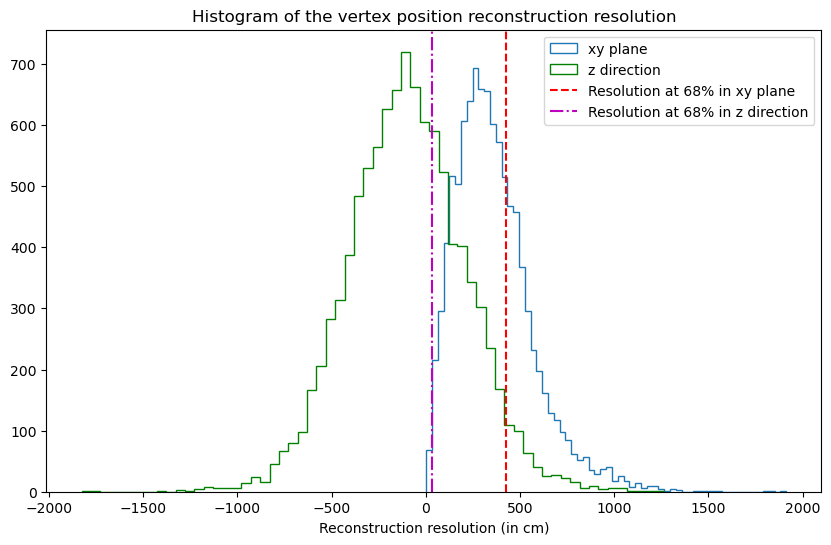

In [23]:
plt.figure(figsize=(10, 6))

plt.hist(xy_norm_pos, bins=62, histtype='step', label='xy plane')
plt.hist(z_norm_pos, bins=62, histtype='step', label='z direction', color='g')

plt.axvline(x=res['xy_position'], color='r', linestyle='--', linewidth=1.5, label='Resolution at 68% in xy plane')
plt.axvline(x=res['z_position'], color='m', linestyle='dashdot', linewidth=1.5, label='Resolution at 68% in z direction')

plt.legend(loc='upper right')
plt.xlabel('Reconstruction resolution (in cm)')
plt.title('Histogram of the vertex position reconstruction resolution')

plt.show()

### Old

In [43]:
normalize_xyz=np.array(label_norma_value)
normalize_t=np.array(label_norma_value)

outputs_vtx = predictions[:,:3]*normalize_xyz[:3]
labels_vtx = targets[:,:3]*normalize_xyz[:3]

outputs_time = predictions[:,3]*normalize_t[3]
labels_time = targets[:,3]*normalize_t[3]

# Compute vertex time+position difference (norm of the 4-vector diff)
norm_pos = outputs_vtx - labels_vtx                              
norm_pos = np.linalg.norm(norm_pos, ord=2, axis=1)                     # Compute x2+y2+z2 for each element of the batch + Take norm
res_pos = np.quantile(norm_pos, 0.68, axis=0)

#Compute vertex time difference (absolute diff of the vector diff)
norm_time = outputs_time - labels_time              # Select the corresponding column
# norm_time = np.abs(norm_time)           # Compute absolute value and rescale to ns
res_time = np.quantile(norm_time, 0.68, axis=0)
cred_interval = np.quantile(norm_time, 0.16, axis=0), np.quantile(norm_time, 0.84, axis=0)

# print(f"Resolution at 68% for:\n- Position: {res_pos:.2f} cm")
print(f"Resolution at 68% for the position for:\n- Position: {res_pos:.2f}cm\n- Time: {res_time:.2f}ns\n- credible interval 68%: {cred_interval[0]:.2f}ns to {cred_interval[1]:.2f}ns ")


Resolution at 68% for the position for:
- Position: 541.89cm
- Time: 574.70ns
- credible interval 68%: 434.68ns to 642.23ns 
